<a href="https://colab.research.google.com/github/leoclementliao/colab-Melanoma/blob/master/E14_gm75_18e_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q efficientnet albumentations gcsfs >> /dev/null

In [ ]:
import pandas as pd, numpy as np
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from google.colab import drive
import gcsfs

GCS_PATH_2020_512 = 'gs://kds-154649568d837568b1118f54c8293475e4b9686f2f6b0d89c6a2183e' # melanoma-512x512
GCS_PATH_2019_512 = 'gs://kds-823a9066a531d4a2cb81f281a88a2235b28df4699c8eaf2a0b1f5208' # isic2019-512x512

GCS_PATH_2020_384 = 'gs://kds-6763fab01fc2e4f17502b8fe494b1880f0979df6b66ea201721f2672' # melanoma-384x384
GCS_PATH_2019_384 = 'gs://kds-fc59a9e49338667ebf41c5be0e8e35f9a8b6bead2f5e44ba68a9c1ca' # isic2019-384x384

fs = gcsfs.GCSFileSystem(project='siic')

In [ ]:
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
output_path = '/content/drive/My Drive/kaggle/SIIM_ISIC/outputs'
version_name = 'E14_gm75_18e_FL'
checkpoint = '/content/drive/My Drive/kaggle/SIIM_ISIC/weights/'+version_name

import os
## Check path for checkpoint 
if not os.path.exists(checkpoint):
    os.makedirs(checkpoint)

In [ ]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [512]*FOLDS

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0,0,0,0,0]
INC2018 = [1,1,1,1,1]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [16]*FOLDS
EPOCHS = [18]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6,6,6,6,6]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

In [ ]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.1.237.250:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


In [ ]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = GCS_PATH_2020_512
    GCS_PATH2[i] = GCS_PATH_2019_512
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

In [ ]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

class GridMask():
    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        # super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)


In [ ]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

## Multi-scale training
def random_IMG_size(img, dim):
    reshape_ratio = tf.random.uniform([1], 0.3,1 )[0]
    reshape_prob = 0.5
    if tf.random.uniform([1])[0]<reshape_prob:
        img = tf.image.resize(img, 
                              [int(dim*reshape_ratio), int(dim*reshape_ratio)])
        img = tf.image.resize_with_crop_or_pad(img, int(1.2*dim), int(1.2*dim))
        img = tf.image.random_crop(img, [dim,dim, 3])
    return img

## Grid Mask
def add_mask(img, dim):
    gm = GridMask(mode=0, num_grid=3)
    gm.init_masks(dim,dim)
    init_masks = tf.cast(gm.masks[0], dtype='float32')
    init_masks = tf.stack([init_masks]*3, axis=2)
    rotated_masks = transform(init_masks, DIM=init_masks.shape[0])
    mask_single = tf.image.random_crop(rotated_masks,[dim,dim,3])
    mask_batch = tf.expand_dims(mask_single, axis=0)
    img = img*mask_batch
    return img


@tf.function
def data_augment(img, dim):
    img = transform(img,DIM=dim)
    img = tf.image.random_flip_left_right(img)
    #img = tf.image.random_hue(img, 0.01)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_brightness(img, 0.1)
    ## Add Grid Mask
    gm_ratio = 0.75
    if tf.random.uniform([1])[0] < gm_ratio:
        img=add_mask(img, dim)
    # ## Multi-scale
    # img = random_IMG_size(img, dim) 
    
    return img

def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0

    if augment: 
        img = data_augment(img, dim)
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)



In [ ]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

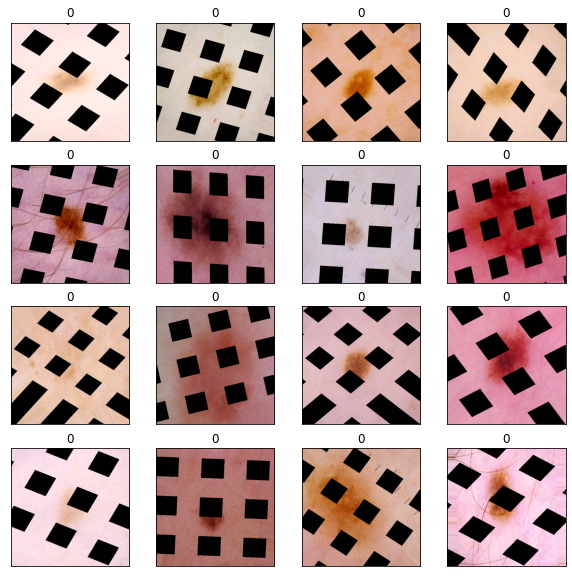

In [ ]:
fold=0

Examples = list(get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]).take(2).as_numpy_iterator())
image_examples = Examples[0][0]
y_examples = Examples[0][1]
IMG_SIZE = IMG_SIZES[0]
plt.figure(figsize=(10,10))
for i in range(16):
    image_plot = np.array(image_examples[i]).reshape([IMG_SIZE,IMG_SIZE,3])
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_plot, cmap=plt.cm.binary)
    plt.title(y_examples[i])

    # print((image_plot<0).sum())
plt.show()

In [ ]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]
def Focal_Loss(y_true, y_pred, alpha=0.75, gamma=2, weight=5):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    BCE = K.binary_crossentropy(y_true, y_pred)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return BCE+weight*focal_loss

def build_model(dim=128, ef=0):
    # inp = tf.keras.layers.Input(shape=(dim,dim,3))
    # base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    inp = tf.keras.layers.Input(shape=(None,None,3))
    base = EFNS[ef](input_shape=(None,None,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    # loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=Focal_Loss,metrics=['AUC'])
    return model

In [ ]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 1
#### Image Size 512 with EfficientNet B6 and batch_size 128
#### Using 2018+2017 external data
#########################
165527552/165527152 [==============================] - 2s 0us/step
Training...
Epoch 1/18
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


284/284 [==============================] - 347s 1s/step - auc: 0.6051 - loss: 0.8259 - val_auc: 0.6845 - val_loss: 0.3837 - lr: 5.0000e-06
Epoch 2/18
284/284 [==============================] - 319s 1s/step - auc: 0.8258 - loss: 0.3990 - val_auc: 0.8469 - val_loss: 0.2107 - lr: 3.6000e-05
Epoch 3/18
284/284 [==============================] - 319s 1s/step - auc: 0.8704 - loss: 0.3575 - val_auc: 0.8757 - val_loss: 0.1893 - lr: 6.7000e-05
Epoch 4/18
284/284 [==============================] - 316s 1s/step - auc: 0.8925 - loss: 0.3327 - val_auc: 0.8947 - val_loss: 0.2017 - lr: 9.8000e-05
Epoch 5/18
284/284 [==============================] - 320s 1s/step - auc: 0.9055 - loss: 0.3116 - val_auc: 0.8945 - val_loss: 0.1797 - lr: 1.2900e-04
Epoch 6/18
284/284 [==============================] - 320s 1s/step - auc: 0.9145 - loss: 0.3022 - val_auc: 0.9093 - val_loss: 0.1744 - lr: 1.6000e-04
Epoch 7/18
284/284 [==============================] - 315s 1s/step - auc: 0.9250 - loss: 0.2845 - val_auc: 0.90

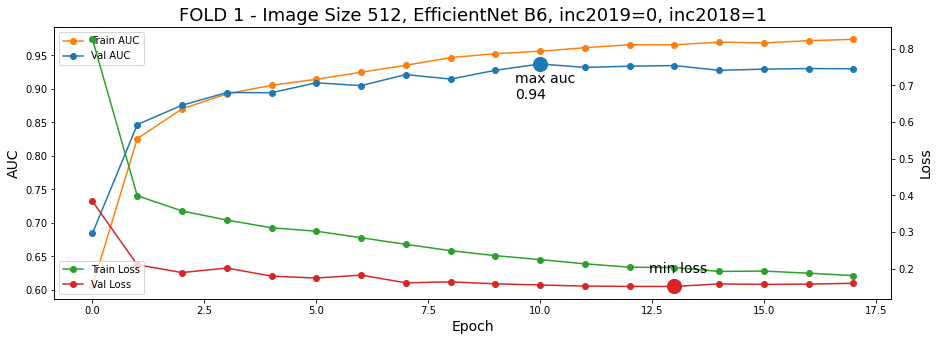

INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 2
#### Image Size 512 with EfficientNet B6 and batch_size 128
#### Using 2018+2017 external data
#########################
Training...
Epoch 1/18
284/284 [==============================] - 348s 1s/step - auc: 0.5858 - loss: 0.8384 - val_auc: 0.7344 - val_loss: 0.3736 - lr: 5.0000e-06
Epoch 2/18
284/284 [==============================] - 322s 1s/step - auc: 0.8246 - loss: 0.4011 - val_auc: 0.8360 - val_loss: 0.2156 - lr: 3.6000e-05
Epoch 3/18
284/284 [==============================] - 317s 1s/step - auc: 0.8792 - loss: 0.3475 - val_auc: 0.8440 - val_loss: 0.2279 - lr: 6.7000e-05
Epoch 4/18
284/284 [==============================] - 322s 1s/step - auc: 0.8956 - loss: 0.3289 - val_auc: 0.8935 - val_loss: 0.1876 - lr: 9.8000e-05
Epoch 5/18
284/284 [==============================] - 317s 1s/step - auc: 0.9090 - loss: 0.3086 - val_auc: 0.8810 - val_loss: 0.2052 - lr: 1.2900e-04
Epoch 6/18
284/284 [==============================] - 317s 1s/step - auc: 0.920

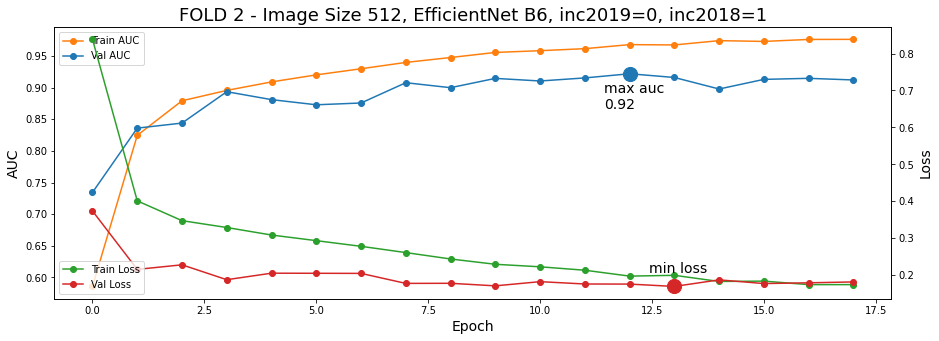

INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 3
#### Image Size 512 with EfficientNet B6 and batch_size 128
#### Using 2018+2017 external data
#########################
Training...
Epoch 1/18
284/284 [==============================] - 350s 1s/step - auc: 0.5754 - loss: 0.8565 - val_auc: 0.7654 - val_loss: 0.3275 - lr: 5.0000e-06
Epoch 2/18
284/284 [==============================] - 322s 1s/step - auc: 0.8255 - loss: 0.4013 - val_auc: 0.8783 - val_loss: 0.1972 - lr: 3.6000e-05
Epoch 3/18
284/284 [==============================] - 323s 1s/step - auc: 0.8743 - loss: 0.3521 - val_auc: 0.9075 - val_loss: 0.1792 - lr: 6.7000e-05
Epoch 4/18
284/284 [==============================] - 323s 1s/step - auc: 0.8952 - loss: 0.3286 - val_auc: 0.9198 - val_loss: 0.1598 - lr: 9.8000e-05
Epoch 5/18
284/284 [==============================] - 323s 1s/step - auc: 0.9039 - loss: 0.3129 - val_auc: 0.9194 - val_loss: 0.1596 - lr: 1.2900e-04
Epoch 6/18
284/284 [==============================] - 323s 1s/step - auc: 0.915

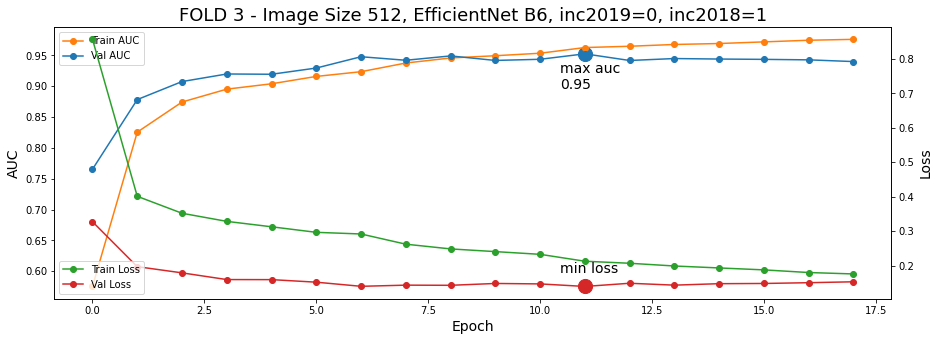

INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 4
#### Image Size 512 with EfficientNet B6 and batch_size 128
#### Using 2018+2017 external data
#########################
Training...
Epoch 1/18
284/284 [==============================] - 350s 1s/step - auc: 0.5958 - loss: 0.8253 - val_auc: 0.7088 - val_loss: 0.3835 - lr: 5.0000e-06
Epoch 2/18
284/284 [==============================] - 322s 1s/step - auc: 0.8282 - loss: 0.3974 - val_auc: 0.8632 - val_loss: 0.2037 - lr: 3.6000e-05
Epoch 3/18
284/284 [==============================] - 322s 1s/step - auc: 0.8731 - loss: 0.3526 - val_auc: 0.8923 - val_loss: 0.1905 - lr: 6.7000e-05
Epoch 4/18
284/284 [==============================] - 322s 1s/step - auc: 0.8862 - loss: 0.3390 - val_auc: 0.9026 - val_loss: 0.1741 - lr: 9.8000e-05
Epoch 5/18
284/284 [==============================] - 317s 1s/step - auc: 0.9048 - loss: 0.3148 - val_auc: 0.8919 - val_loss: 0.1808 - lr: 1.2900e-04
Epoch 6/18
284/284 [==============================] - 318s 1s/step - auc: 0.908

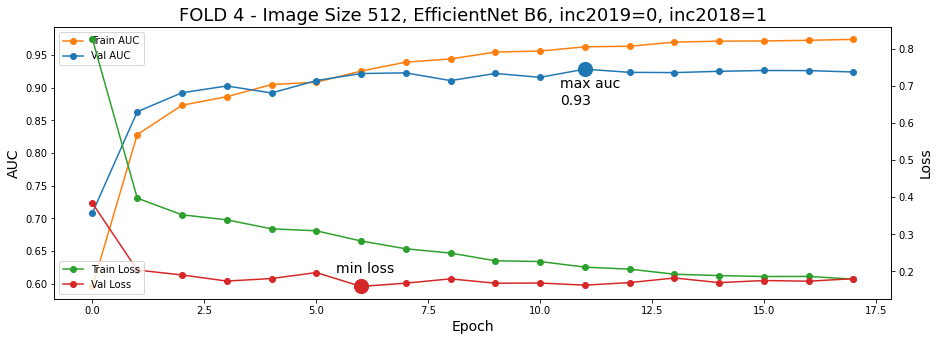

INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.1.237.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 5
#### Image Size 512 with EfficientNet B6 and batch_size 128
#### Using 2018+2017 external data
#########################
Training...
Epoch 1/18
284/284 [==============================] - 348s 1s/step - auc: 0.5721 - loss: 0.8434 - val_auc: 0.7265 - val_loss: 0.3469 - lr: 5.0000e-06
Epoch 2/18
284/284 [==============================] - 321s 1s/step - auc: 0.8290 - loss: 0.3994 - val_auc: 0.8510 - val_loss: 0.2105 - lr: 3.6000e-05
Epoch 3/18
284/284 [==============================] - 322s 1s/step - auc: 0.8731 - loss: 0.3495 - val_auc: 0.8813 - val_loss: 0.1879 - lr: 6.7000e-05
Epoch 4/18
284/284 [==============================] - 322s 1s/step - auc: 0.8921 - loss: 0.3311 - val_auc: 0.8927 - val_loss: 0.1807 - lr: 9.8000e-05
Epoch 5/18
284/284 [==============================] - 316s 1s/step - auc: 0.9054 - loss: 0.3171 - val_auc: 0.8983 - val_loss: 0.1815 - lr: 1.2900e-04
Epoch 6/18
284/284 [==============================] - 322s 1s/step - auc: 0.911

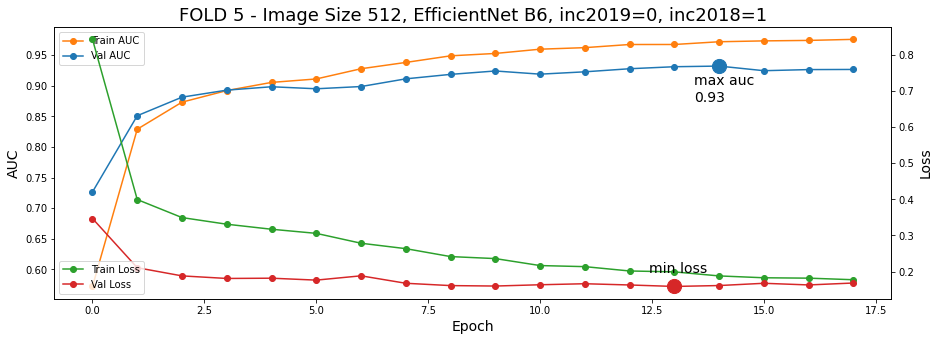

In [ ]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        checkpoint+'/fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
        verbose=VERBOSE
    )
    
    print('Loading best model...')
    model.load_weights(checkpoint+'/fold-%i.h5'%fold)
    
    # PREDICT OOF USING TTA
    test_batch_scale = 3
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*test_batch_scale)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/test_batch_scale/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*test_batch_scale)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/test_batch_scale/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()

In [ ]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv(f'{output_path}/{version_name}_oof.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.936


,image_name,target,pred,fold
0,ISIC_2637011,0,0.009357,0
1,ISIC_0076262,0,0.007959,0
2,ISIC_0074268,0,0.000029,0
3,ISIC_0015719,0,0.000010,0
4,ISIC_0082543,0,0.000593,0


In [ ]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [ ]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv(f'{output_path}/{version_name}_sub.csv', index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.000751
1443,ISIC_0052349,0.000645
3120,ISIC_0058510,0.000434
4870,ISIC_0073313,0.000827
5494,ISIC_0073502,0.019058
